In [1]:
import pathlib
import os

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

from utilities import dimensions as dim, fano, laser
from utilities.rmt import packaging


In [2]:
%matplotlib ipympl


In [3]:
REFERENCE_XUV_eV = 45.547
REFERENCE_NIR_eV = 1.423


In [4]:
def energy_range(array: np.ndarray, energy_eV: np.ndarray, low_eV: float, high_eV: float):
    assert len(array.shape) == len(energy_eV.shape) == 1
    assert array.size == energy_eV.size
    return array[(low_eV < energy_eV) & (energy_eV < high_eV)]

def absorption(energy, reduced_dipole):
    return 4 * np.pi * energy * np.imag(reduced_dipole) / 137.056

def read(path: pathlib.Path, low_eV: float = 44, high_eV: float = 45.8):
    d = np.loadtxt(path.joinpath("TAS_0001_z"))
    E = energy_range(d[:, 0], d[:, 0], low_eV, high_eV)
    s = energy_range(d[:, 1], d[:, 0], low_eV, high_eV)

    return E, -s


In [5]:
def fit(energy, spectrum):
    def f(E, m, c, r, s, p, w):
        fano_profile = fano.Fano(r, s, p, w)
        return fano.lineshape(E, m, c, fano_profile)

    p0 = [0, 0, 46.5, 1, 0, 1]
    lbounds = [-1, -1, 46, 0, -np.pi, 0]
    ubounds = [1, 1, 47, np.inf, np.pi, np.inf]

    (m, c, r, s, p, w), _ = sp.optimize.curve_fit(
        f,
        energy,
        spectrum,
        p0,
        bounds=(lbounds, ubounds),
        maxfev=999999,
    )

    return (m, c, fano.Fano(r, s, p, w))


In [6]:
calc_dir = pathlib.Path(".").parent.joinpath("17", "gaussian", "nir-fwhm=3cycles", "delay=+07.000fs")

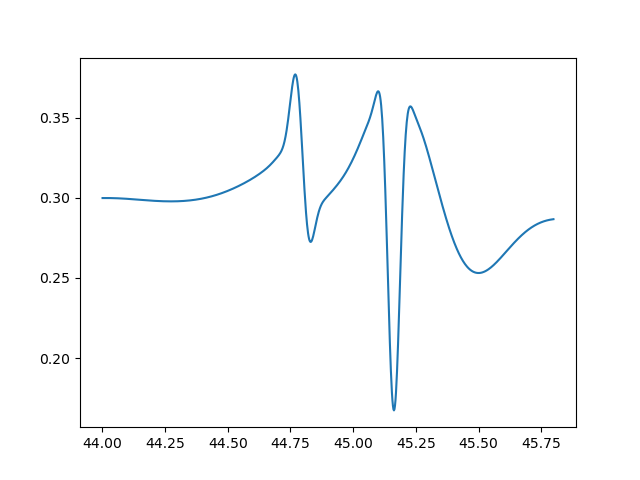

In [7]:
E, s = read(calc_dir)

fig, ax = plt.subplots(1, 1)
ax.plot(E, s)


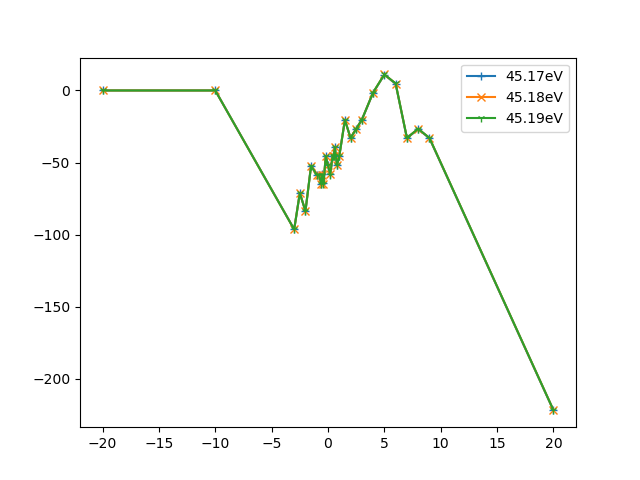

In [8]:
def floatify(delay_dir):
    return float(delay_dir.name[6:-2])

delay_dirs = sorted(pathlib.Path().joinpath("17", "gaussian", "nir-fwhm=3cycles").iterdir(), key=floatify)

delay = np.zeros(len(delay_dirs))
phase_45_17eV = np.zeros(len(delay_dirs))
phase_45_18eV = np.zeros(len(delay_dirs))
phase_45_19eV = np.zeros(len(delay_dirs))

for i, delay_dir in enumerate(delay_dirs):
    delay[i] = floatify(delay_dir)

    dr_path = delay_dir.joinpath("response_0001_z_reduced_real")
    if not dr_path.exists():
        continue
    dr = np.loadtxt(dr_path)

    di_path = delay_dir.joinpath("response_0001_z_reduced_imag")
    if not di_path.exists():
        continue
    di = np.loadtxt(di_path)

    assert np.allclose(dr[:, 0], di[:, 0])

    E = dr[:, 0]
    p = np.unwrap(np.angle(dr[:, 1] + di[:, 1]*1j))
    p = p[(45.1 < E) & (E < 45.3)]
    E = E[(45.1 < E) & (E < 45.3)]

    phase = sp.interpolate.make_interp_spline(E, p)

    phase_45_17eV[i] = phase(45.17)
    phase_45_18eV[i] = phase(45.18)
    phase_45_19eV[i] = phase(45.19)

fig, ax = plt.subplots(1, 1)
ax.plot(delay, phase_45_17eV, marker="+", label="45.17eV")
ax.plot(delay, phase_45_18eV, marker="x", label="45.18eV")
ax.plot(delay, phase_45_19eV, marker="1", label="45.19eV")
ax.legend()


In [9]:
dim.PhotonEnergy.from_eV(1.423).period().to_fs() / 2

1.45314768913021

/var/folders/k_/dzxc598908l6_mz8sk184j2m0000gp/T/ipykernel_18000/673519403.py:53: RuntimeWarning: divide by zero encountered in divide
  ax_f.plot(f_eV[(low_eV < f_eV) & (f_eV < high_eV)], (-4 * np.pi * f_au * np.imag(dipole_F / e_field_F))[(low_eV < f_eV) & (f_eV < high_eV)], label="XUV + Window Absorption Spectrum")


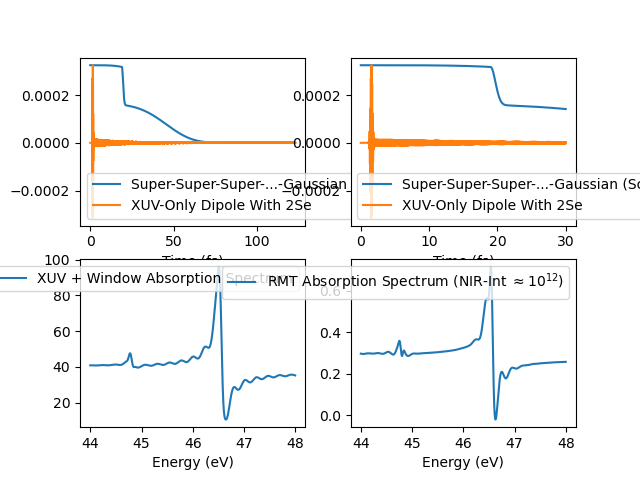

In [22]:
d = np.loadtxt(pathlib.Path().joinpath("11/RMT/xuv=45.547eV/expec_z_all.xuv-only00000000"), skiprows=1)
t = d[:, 0]
z = d[:, 1]

dt = np.diff(t)
assert np.allclose(dt, dt[0])
dt = dt[0]

nir_time = dim.Time.from_fs(20)

low_eV = 44
high_eV = 48
data_E, data_s = read(pathlib.Path(f"11/RMT/xuv=45.547eV-nir=1.423eV/int=0.050/delay={nir_time.to_fs():+z07.3f}fs"), low_eV, high_eV)

nir_steps = round(nir_time.to_au() / dt)

nir_window_start_time = dim.Time.from_fs(nir_time.to_fs() - 1)
nir_window_start_steps = round(nir_window_start_time.to_au() / dt)

nir_window = np.ones_like(t)
nir_window[nir_window_start_steps:] = 1 - 0.50 * (1 - np.exp(-dim.Time.from_au(t[nir_window_start_steps:] - nir_window_start_time.to_au()).to_fs()**2))
window = np.exp(-(np.linspace(0, 2.5, z.size))**4)

t_fs = dim.Time.from_au(t).to_fs()

dipole_t = np.arange(10 * t.size) * dt
assert np.allclose(dipole_t[:t.size], t)
dipole_f = dim.Energy.from_au(2 * np.pi * sp.fft.rfftfreq(dipole_t.size, dt))

e_field = laser.EFieldDataXUVOnly.gaussian(dim.PhotonEnergy.from_eV(45.547))
e_field_z = e_field.pulse(dipole_t)
e_field_F = sp.fft.rfft(e_field_z)

dipole_z = np.zeros_like(dipole_t)
dipole_z[:z.size] = z * nir_window * window
dipole_F = sp.fft.rfft(dipole_z)

f_eV = dipole_f.to_eV()
f_au = dipole_f.to_au()

fig, [[ax_t, ax_tz], [ax_f, ax_fd]] = plt.subplots(2, 2)

ax_t.plot(t_fs, nir_window * np.max(z) * window, label="Super-Super-Super-...-Gaussian (Scaled)")
ax_t.plot(t_fs, z, label="XUV-Only Dipole With 2Se")
ax_t.set_xlabel("Time (fs)")
ax_t.legend()

ax_tz.plot(t_fs[t_fs < nir_time.to_fs() + 10], (nir_window * window * np.max(z))[t_fs < nir_time.to_fs() + 10], label="Super-Super-Super-...-Gaussian (Scaled)")
ax_tz.plot(t_fs[t_fs < nir_time.to_fs() + 10], z[t_fs < nir_time.to_fs() + 10], label="XUV-Only Dipole With 2Se")
ax_tz.set_xlabel("Time (fs)")
ax_tz.legend()

ax_f.plot(f_eV[(low_eV < f_eV) & (f_eV < high_eV)], (-4 * np.pi * f_au * np.imag(dipole_F / e_field_F))[(low_eV < f_eV) & (f_eV < high_eV)], label="XUV + Window Absorption Spectrum")
ax_f.set_xlabel("Energy (eV)")
ax_f.legend()

ax_fd.plot(data_E, data_s, label=r"RMT Absorption Spectrum (NIR-Int $\approx 10^{{12}}$)")
ax_fd.set_xlabel("Energy (eV)")
ax_fd.legend()


In [11]:
def finite_time_fano(E, m, c, A, B, C, Er, G, q, t):
    e = 2 * (E - Er) / G
    return m * E + c + np.real(A + (q - 1j)**2 * (B - C*np.exp(-G * t * (1 - e*1j) / 2)) / (1 - e*1j))

def fit_finite_time_fano(E, s):
    p0 = [0, 0, 1, 1, 1, 46.5, 1, 0, 10]
    lb = [-1, -1, 0, 0, 0, 46, 0, -np.inf, 0]
    ub = [1, 1, np.inf, np.inf, np.inf, 47, np.inf, np.inf, np.inf]

    p, c = sp.optimize.curve_fit(finite_time_fano, E, s, p0, bounds=(lb, ub))

    e = np.sqrt(np.diag(c))

    return p, e


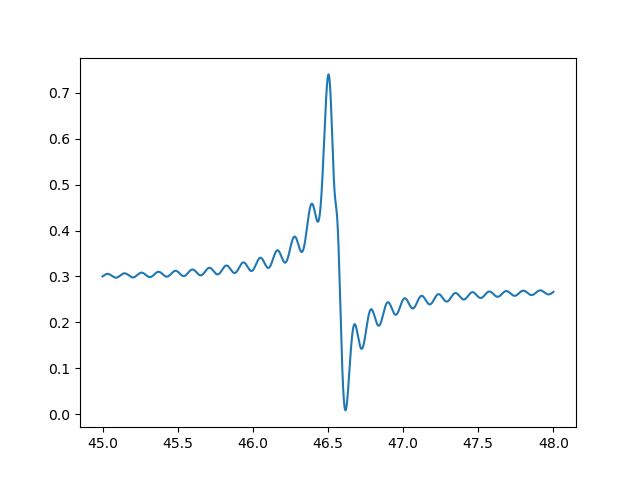

In [12]:
E = np.linspace(45, 48, 10000)
s = finite_time_fano(
    E,
    -0.0025,  # m
    -0.6,  # c
    1,  # A
    0.2,  # B
    0.4,  # C
    46.55,  # Er
    0.07,  # G
    -1.5,  # q
    55.67,  # t
)

fig, ax = plt.subplots(1, 1)
ax.plot(E, s)


[-2.51605660e-03 -1.91164019e-01  5.87297366e-01  2.23187506e-01
  2.93373815e-01  4.65482312e+01  7.15677574e-02 -1.54409845e+00
  6.11949212e+01]
[0.00049933 0.01167929 0.01167929 0.00187588 0.00619532 0.00024322
 0.0005145  0.00779375 0.11662296]


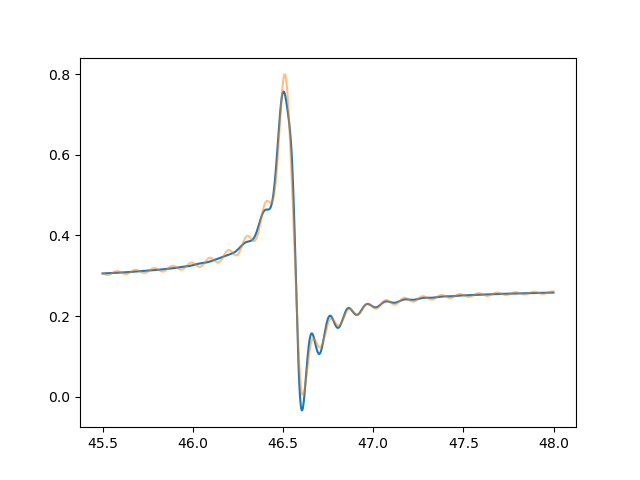

In [13]:
E, s = read(pathlib.Path().joinpath("20", "RMT", "Without-2Se", "xuv=45.547eV-nir=1.423eV", "int=0.100", "delay=+40.000fs"), low_eV=45.5, high_eV=48)

p, e = fit_finite_time_fano(E, s)
print(p)
print(e)

fig, ax = plt.subplots(1, 1)
ax.plot(E, s)
ax.plot(E, finite_time_fano(E, *p), alpha=0.5)

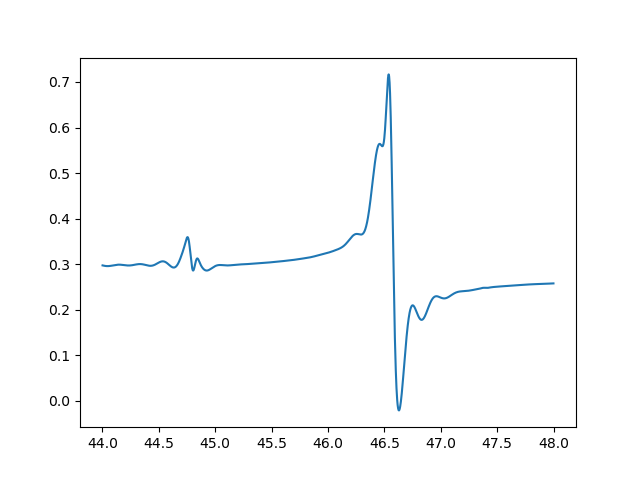

In [14]:
E, s = read(pathlib.Path().joinpath("11", "RMT", "xuv=45.547eV-nir=1.423eV", "int=0.050", "delay=+20.000fs"), high_eV=48)

fig, ax = plt.subplots(1, 1)
ax.plot(E, s)

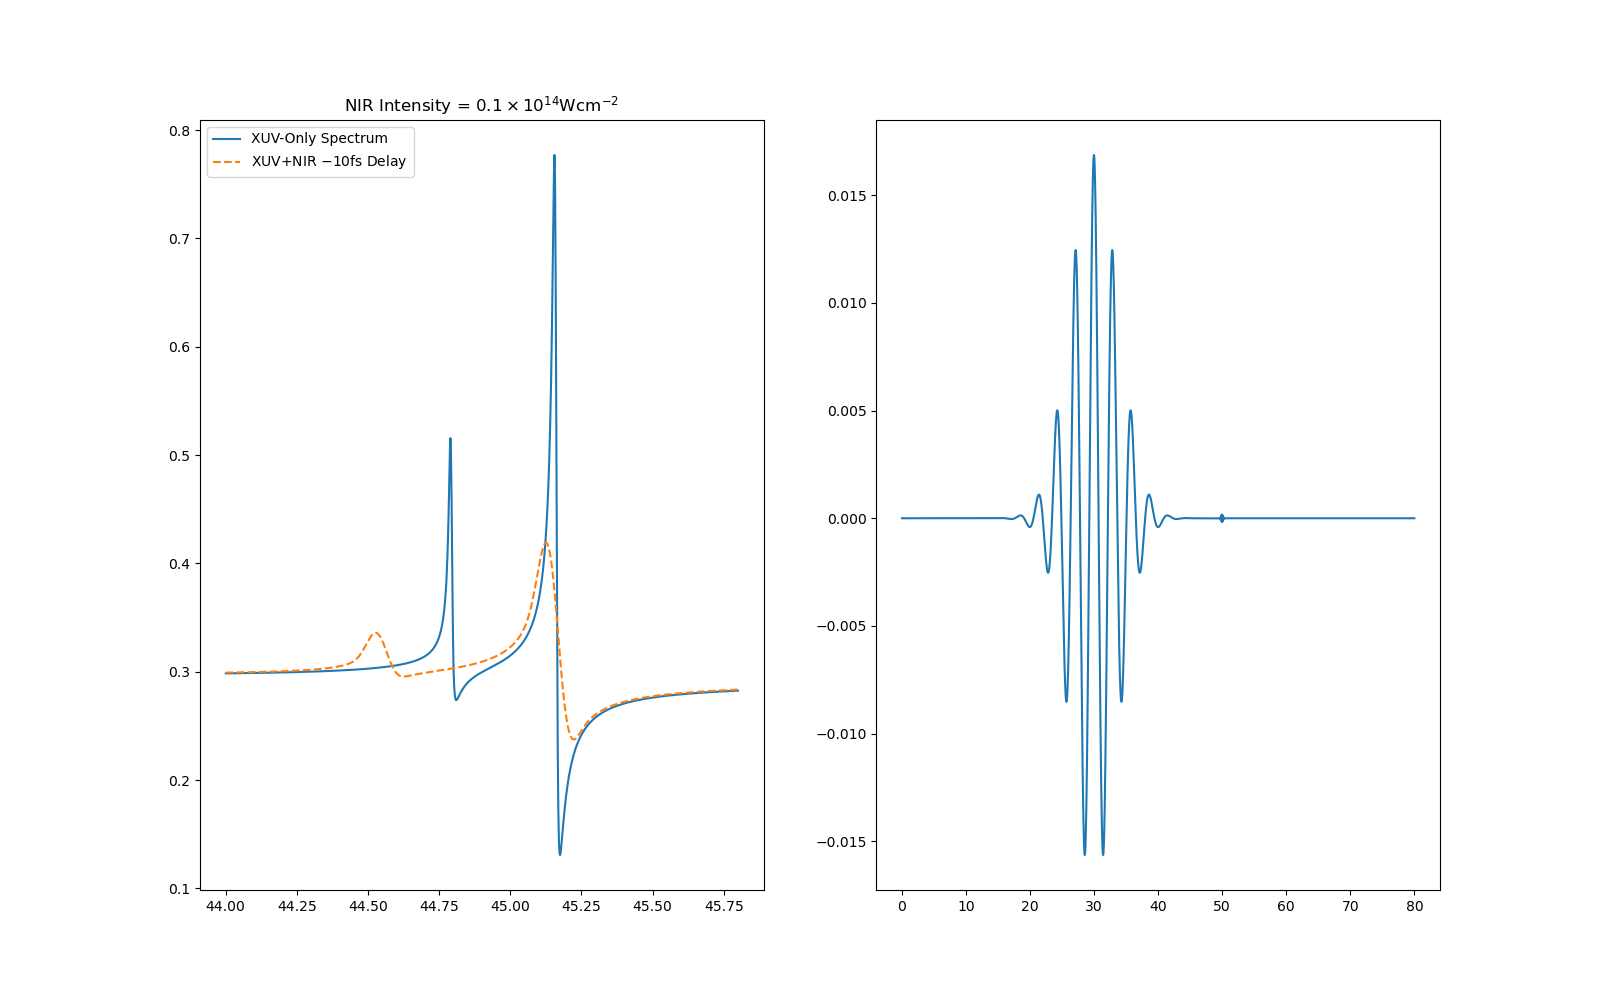

In [15]:
delay = -20.0
intensity = 0.1

if intensity > 0.01:
    E_nir, s_nir = read(pathlib.Path(f"20/RMT/With-2Se/xuv=45.547eV-nir=1.423eV/int={intensity:5.3f}/delay={delay:+z07.3f}fs"))
else:
    E_nir, s_nir = read(pathlib.Path(f"17/gaussian/nir-fwhm=3cycles/delay={delay:+z07.3f}fs"))

E_xuv, s_xuv = read(pathlib.Path(".").parent.joinpath("17", "gaussian", "xuv-int=0.0100", "xuv=45.547eV"))

E_field = laser.EFieldDataNIRAndXUV.gaussian(dim.PhotonEnergy.from_eV(1.423), dim.PhotonEnergy.from_eV(45.547), dim.Time.from_fs(delay), dim.EFieldIntensity.from_100_TW_per_cm2(intensity))

fig, [ax_OD, ax_E] = plt.subplots(1, 2, figsize=(16, 10))

ax_OD.plot(E_xuv, s_xuv, label="XUV-Only Spectrum")
ax_OD.plot(E_nir, s_nir, "--", label=r"XUV+NIR $-10\text{fs}$ Delay")
ax_OD.set_title(f"NIR Intensity = ${intensity} \\times 10^{{14}} \\text{{W}}\\text{{cm}}^{{-2}}$")
ax_OD.legend()

E_field_data = E_field.e_field(dim.Time.from_fs(80))
t = E_field_data[:, 0]
z = E_field_data[:, 3]
ax_E.plot(dim.Time.from_au(t).to_fs(), z)


In [16]:
dim.Energy.from_au(dim.EFieldIntensity.from_100_TW_per_cm2(0.1).amplitude().to_au()**2 / (4 * dim.PhotonEnergy.from_eV(1.423).to_au()**2)).to_eV()

0.7082896536495732